## Propensity To Buy Prediction
## Data used for analysis is based on Integral Life Admin System

### The SQL query in below cells will retreive data based on database credentials provide. Right now these credentials have been left empty for security reasons. Please enter relevant details before running this notebook further.

In [1]:
# Import Packages
import numpy as np
import pandas as pd
import pyodbc

# For Graphics
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# For splitting data into test and train subsets
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

# For logistic regression
from sklearn.linear_model import LogisticRegression

# For saving the model
from sklearn.externals import joblib 

# For Confusion Matrix
from sklearn import metrics

# For ROC Curve
from sklearn.metrics import roc_auc_score, roc_curve

# For Normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# For Feature Selection
from sklearn.feature_selection import chi2, SelectKBest

# Settings to view all columns and rows
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

C:\Users\tbhardwaj2\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Import Data

In [2]:
# Enter ip address and port number of the system where the database resides.
server   = *******
database = *******
username = *******
password = ******* 

In [47]:
# Add appropriate driver name
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

In [48]:
# Run Query
query = '''SELECT 
Q1.CLIENT_NUMBER,
Q1.HAS_BOUGHT_MORE,
SUM(Q1.NUMBER_OF_COVERAGES) AS NUMBER_OF_COVERAGES,
Q1.FEMALE,
Q1.MALE,
Q1.GENDER_UNKNOWN,
Q1.MARRIED,
Q1.DIVORCED,
Q1.SINGLE,
Q1.MARITAL_STATUS_UNKNOWN,
Q1.PROFESSION,
Q1.CHILD,
Q1.YOUTH,
Q1.ADULT,
Q1.SENIOR_CITIZEN,
Q1.NON_SMOKER,
Q1.SMOKER,
Q1.UNDER_WEIGHT,
Q1.NORMAL_WEIGHT,
Q1.OVER_WEIGHT,
Q1.OBESE,
Q1.Q1_BUY,
Q1.Q2_BUY,
Q1.Q3_BUY,
Q1.Q4_BUY,
SUM(Q1.PREMIUM_PAID) AS PREMIUM_PAID

FROM
(
SELECT DISTINCT
CLNT.CLNTNUM AS 'CLIENT_NUMBER',
CASE
WHEN 
Q1.UNIQUE_PRODUCTS > 1 
THEN 
1
ELSE
0
END 
AS 'HAS_BOUGHT_MORE',
CASE
WHEN
COVR.COVERS IS NULL
THEN
0
ELSE
COVR.COVERS
END AS NUMBER_OF_COVERAGES,
CASE 
WHEN 
CLNT.CLTSEX = 'F'
THEN 
'1'
ELSE
'0'
END AS 'FEMALE',
CASE 
WHEN 
CLNT.CLTSEX = 'M'
THEN 
'1'
ELSE
'0'
END AS 'MALE',
CASE 
WHEN 
CLNT.CLTSEX = ''
THEN 
'1'
ELSE
'0'
END AS 'GENDER_UNKNOWN',
CASE 
WHEN 
CLNT.MARRYD = 'M'
THEN 
'1'
ELSE
'0'
END AS 'MARRIED',
CASE 
WHEN 
CLNT.MARRYD = 'D'
THEN 
'1'
ELSE
'0'
END AS 'DIVORCED',
CASE 
WHEN 
CLNT.MARRYD = 'S'
THEN 
'1'
ELSE
'0'
END AS 'SINGLE',
CASE 
WHEN 
CLNT.MARRYD IN ('J', 'L', 'C', 'Z')
THEN 
'1'
ELSE
'0'
END AS 'MARITAL_STATUS_UNKNOWN',
CASE
WHEN
LIFE.OCCUP = ''
THEN
'PROF_UNKNOWN'
ELSE
rtrim(T3644.LONGDESC)
END  AS 'PROFESSION',
CASE
WHEN LIFE.ANBCCD BETWEEN 0 AND 14
THEN 
'1'
ELSE
'0' 
END AS 'CHILD',
CASE
WHEN LIFE.ANBCCD BETWEEN 15 AND 24
THEN 
'1'
ELSE
'0' 
END AS 'YOUTH',
CASE
WHEN LIFE.ANBCCD BETWEEN 25 AND 64
THEN 
'1'
ELSE
'0' 
END AS 'ADULT',
CASE
WHEN LIFE.ANBCCD > 65 
THEN 
'1'
ELSE
'0' 
END AS 'SENIOR_CITIZEN',
CASE
WHEN
LIFE.SMOKING = 'N'
THEN
'1'
ELSE
'0'
END AS 'NON_SMOKER',
CASE
WHEN
LIFE.SMOKING <> 'N'
THEN
'1'
ELSE
'0'
END AS 'SMOKER',

CASE 
WHEN
UNDL.BMI < 18.5
THEN
'1'
ELSE
'0'
END AS 'UNDER_WEIGHT',
CASE 
WHEN
UNDL.BMI BETWEEN 18.5 AND 24.9
THEN
'1'
ELSE
'0'
END AS 'NORMAL_WEIGHT',
CASE 
WHEN
UNDL.BMI BETWEEN 25 AND 29.9
THEN
'1'
ELSE
'0'
END AS 'OVER_WEIGHT',
CASE 
WHEN
UNDL.BMI > 30
THEN
'1'
ELSE
'0'
END AS 'OBESE',

(COALESCE(QQ.[01],0) + COALESCE(QQ.[02],0) + COALESCE(QQ.[03],0)) AS Q1_BUY, 
(COALESCE(QQ.[04],0) + COALESCE(QQ.[05],0) + COALESCE(QQ.[06],0)) AS Q2_BUY, 
(COALESCE(QQ.[07],0) + COALESCE(QQ.[08],0) + COALESCE(QQ.[09],0)) AS Q3_BUY, 
(COALESCE(QQ.[10],0) + COALESCE(QQ.[11],0) + COALESCE(QQ.[12],0)) AS Q4_BUY,

isnull(ACMV.PREMIUM_PAID,0) as PREMIUM_PAID

FROM 
VM1DTA.CLNTPF CLNT

INNER JOIN 

(SELECT  COWNNUM, COUNT( DISTINCT CNTTYPE) UNIQUE_PRODUCTS FROM VM1DTA.CHDRPF WHERE VALIDFLAG = '1' AND CHDRCOY = '2' 
GROUP BY COWNNUM
HAVING COUNT( DISTINCT CNTTYPE) > 0
) Q1

ON CLNT.CLNTNUM = Q1.COWNNUM

LEFT OUTER JOIN 
(SELECT LIFE01.CHDRNUM, LIFE01.VALIDFLAG, LIFE01.LIFE, LIFE01.JLIFE, LIFE01.LIFCNUM, LIFE01.OCCUP, LIFE01.SMOKING, LIFE01.ANBCCD
FROM
(select UNIQUE_NUMBER, CHDRNUM, VALIDFLAG, LIFCNUM, LIFE, JLIFE, OCCUP, SMOKING, ANBCCD  from VM1DTA.LIFEPF LIFE01 ) LIFE01 
inner join 
(SELECT LIFCNUM, MAX(UNIQUE_NUMBER) AS MAX_UNIQUE_NUMBER FROM VM1DTA.LIFEPF GROUP BY LIFCNUM) LIFE02 
ON LIFE01.LIFCNUM = LIFE02.LIFCNUM AND LIFE01.UNIQUE_NUMBER = LIFE02.MAX_UNIQUE_NUMBER ) LIFE
ON LIFE.LIFCNUM = CLNT.CLNTNUM

INNER JOIN 
VM1DTA.UNDLPF UNDL
ON UNDL.CHDRNUM = LIFE.CHDRNUM AND UNDL.LIFE = LIFE.LIFE AND UNDL.JLIFE = LIFE.JLIFE

LEFT  OUTER JOIN 
(select rdocnum, SUM (ACCTAMT) PREMIUM_PAID from vm1dta.acmvpf where SACSCODE='LE' AND SACSTYP IN ('LP','SP') 
and batctrcde in ('B522', 'T679', 'T642') GROUP BY RDOCNUM) ACMV
ON ACMV.RDOCNUM  = UNDL.CHDRNUM

LEFT  OUTER JOIN 
(select chdrnum, count(distinct crtable) covers from vm1dta.covrpf where VALIDFLAG='1'
GROUP BY chdrnum) covr
ON COVR.CHDRNUM  = UNDL.CHDRNUM

INNER JOIN
(SELECT *
FROM
(
  SELECT DISTINCT COWNNUM, COUNT(DISTINCT CHDRNUM) AS COUNTING,SUBSTRING((CAST(OCCDATE AS CHAR)),5,2) AS QQ FROM VM1DTA.CHDRPF WHERE VALIDFLAG = '1' 
  GROUP BY COWNNUM, SUBSTRING((CAST(OCCDATE AS CHAR)),5,2)
) AS SourceTable PIVOT( SUM(COUNTING) FOR [QQ] IN([01], [02],[03], [04],[05], [06],[07], [08],[09], [10],[11],
 [12])) AS PivotTable ) QQ

 ON QQ.COWNNUM = CLNT.CLNTNUM

LEFT OUTER JOIN
VM1DTA.DESCPF T3644
ON T3644.DESCITEM = LIFE.OCCUP AND T3644.DESCTABL = 'T3644' AND T3644.LANGUAGE = 'E' AND T3644.DESCCOY = '9'

WHERE CLNT.VALIDFLAG = '1'  AND LIFE.VALIDFLAG = '1' 
) Q1

GROUP BY 
Q1.CLIENT_NUMBER,
Q1.HAS_BOUGHT_MORE,
Q1.FEMALE,
Q1.MALE,
Q1.GENDER_UNKNOWN,
Q1.MARRIED,
Q1.DIVORCED,
Q1.SINGLE,
Q1.MARITAL_STATUS_UNKNOWN,
Q1.PROFESSION,
Q1.CHILD,
Q1.YOUTH,
Q1.ADULT,
Q1.SENIOR_CITIZEN,
Q1.NON_SMOKER,
Q1.SMOKER,
Q1.UNDER_WEIGHT,
Q1.NORMAL_WEIGHT,
Q1.OVER_WEIGHT,
Q1.OBESE,
Q1.Q1_BUY,
Q1.Q2_BUY,
Q1.Q3_BUY,
Q1.Q4_BUY

ORDER BY Q1.CLIENT_NUMBER

'''

In [49]:
# Read data
df_orig = pd.read_sql(query,cnxn)

# Close the cursor
cursor.close() 

In [50]:
# Check data sample
df_orig.head()

CLIENT_NUMBER  HAS_BOUGHT_MORE  NUMBER_OF_COVERAGES FEMALE MALE  \
0      0001529                 1                    7      0    1   
1      0001575                 1                    1      0    1   
2      0001578                 1                    2      0    1   
3      0001580                 1                    1      0    1   
4      0001588                 1                    1      0    1   

  GENDER_UNKNOWN MARRIED DIVORCED SINGLE MARITAL_STATUS_UNKNOWN  \
0              0       0        0      0                      0   
1              0       0        0      1                      0   
2              0       1        0      0                      0   
3              0       1        0      0                      0   
4              0       0        0      1                      0   

            PROFESSION CHILD YOUTH ADULT SENIOR_CITIZEN NON_SMOKER SMOKER  \
0            Architect     0     0     1              0          1      0   
1         PROF_UNKNOWN     0     1     0              0          1      0   
2              Analyst     0     0     1              0          1      0   
3         PROF_UNKNOWN     0     0     1              0          1      0   
4  Business Consultant     0     1     0              0          0      1   

  UNDER_WEIGHT NORMAL_WEIGHT OVER_WEIGHT OBESE  Q1_BUY  Q2_BUY  Q3_BUY  \
0            0             0           0     1      18       2       2   
1            1             0           0     0       1       1       0   
2            1             0           0     0       9       0       0   
3            0             1           0     0      12       0       0   
4            1             0           0     0      10       0       0   

   Q4_BUY  PREMIUM_PAID  
0       0      41472.17  
1       0      10000.00  
2       0       4009.00  
3       1       5000.00  
4       0       5900.00

## Data Analysis & Visualization

In [51]:
# Check data shape
df_orig.shape

(1743, 26)

In [52]:
# Check data attributes of the columns
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1743 entries, 0 to 1742
Data columns (total 26 columns):
CLIENT_NUMBER             1743 non-null object
HAS_BOUGHT_MORE           1743 non-null int64
NUMBER_OF_COVERAGES       1743 non-null int64
FEMALE                    1743 non-null object
MALE                      1743 non-null object
GENDER_UNKNOWN            1743 non-null object
MARRIED                   1743 non-null object
DIVORCED                  1743 non-null object
SINGLE                    1743 non-null object
MARITAL_STATUS_UNKNOWN    1743 non-null object
PROFESSION                1743 non-null object
CHILD                     1743 non-null object
YOUTH                     1743 non-null object
ADULT                     1743 non-null object
SENIOR_CITIZEN            1743 non-null object
NON_SMOKER                1743 non-null object
SMOKER                    1743 non-null object
UNDER_WEIGHT              1743 non-null object
NORMAL_WEIGHT             1743 non-null object
OV

In [53]:
# View distribution of 'Lapse' Instances
df_orig['HAS_BOUGHT_MORE'].value_counts()

0    1426
1     317
Name: HAS_BOUGHT_MORE, dtype: int64

In [54]:
# Check if there are any nulls
df_orig.isnull().sum()

CLIENT_NUMBER             0
HAS_BOUGHT_MORE           0
NUMBER_OF_COVERAGES       0
FEMALE                    0
MALE                      0
GENDER_UNKNOWN            0
MARRIED                   0
DIVORCED                  0
SINGLE                    0
MARITAL_STATUS_UNKNOWN    0
PROFESSION                0
CHILD                     0
YOUTH                     0
ADULT                     0
SENIOR_CITIZEN            0
NON_SMOKER                0
SMOKER                    0
UNDER_WEIGHT              0
NORMAL_WEIGHT             0
OVER_WEIGHT               0
OBESE                     0
Q1_BUY                    0
Q2_BUY                    0
Q3_BUY                    0
Q4_BUY                    0
PREMIUM_PAID              0
dtype: int64

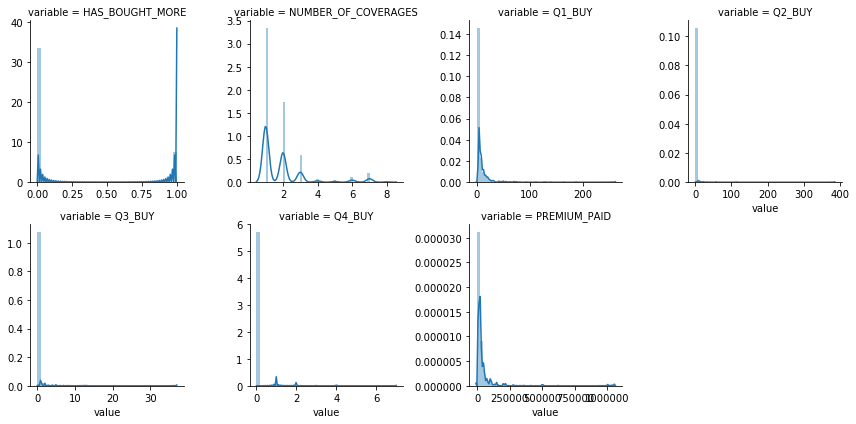

In [55]:
# Study distribution of Numerical Columns
num = [f for f in df_orig.columns if df_orig.dtypes[f] != 'object']
nd = pd.melt(df_orig, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

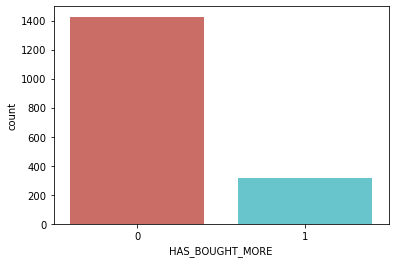

In [56]:
# Plot count values
df_orig.HAS_BOUGHT_MORE.value_counts()
sns.countplot(x = 'HAS_BOUGHT_MORE', data = df_orig, palette = 'hls')
plt.show()

## Data Treatment

In [57]:
# Separate features into categorical and numerical category
cat_vars = ['FEMALE','MALE','GENDER_UNKNOWN','MARRIED','DIVORCED',
            'SINGLE','MARITAL_STATUS_UNKNOWN','PROFESSION','CHILD',
            'YOUTH','ADULT','SENIOR_CITIZEN','NON_SMOKER','SMOKER',
            'UNDER_WEIGHT','NORMAL_WEIGHT','OVER_WEIGHT','OBESE']

num_vars = ['Q1_BUY', 'Q2_BUY', 'Q3_BUY','Q4_BUY', 'PREMIUM_PAID']

In [58]:
# Create a copy of dataframe
df_work = df_orig.copy()

In [59]:
# Convert to 'category' object type
for var in cat_vars:
    df_work[var] = df_work[var].astype('category')

In [60]:
# Create Dummy Variables for categorical variables
for var in cat_vars:
    cat_list = 'var'+'_'+var
    cat_list = pd.get_dummies(df_work[var], prefix=var)
    dummy_data = df_work.join(cat_list)
    df_work = dummy_data

In [61]:
# Check data shape after dummy encoding
df_work.shape

(1743, 92)

In [62]:
# Remove original columns for which dummy variables have been created and ones which will not be required for prediction
vars_remove = ['FEMALE','MALE','GENDER_UNKNOWN','MARRIED','DIVORCED','SINGLE','MARITAL_STATUS_UNKNOWN',
               'PROFESSION','CHILD','YOUTH','ADULT','SENIOR_CITIZEN','NON_SMOKER','SMOKER', 
               'UNDER_WEIGHT','NORMAL_WEIGHT','OVER_WEIGHT','OBESE','CLIENT_NUMBER']

for var in vars_remove:
    df_work=df_work.drop(var, axis=1)

In [63]:
# Normalize numerical columns
scaler = MinMaxScaler()
df_work['Q1_BUY'] = scaler.fit_transform(df_work['Q1_BUY'].values.reshape(-1,1))
df_work['Q2_BUY'] = scaler.fit_transform(df_work['Q2_BUY'].values.reshape(-1,1))
df_work['Q3_BUY'] = scaler.fit_transform(df_work['Q3_BUY'].values.reshape(-1,1))
df_work['Q4_BUY'] = scaler.fit_transform(df_work['Q4_BUY'].values.reshape(-1,1))
df_work['PREMIUM_PAID'] = scaler.fit_transform(df_work['PREMIUM_PAID'].values.reshape(-1,1))

In [64]:
# Create separate dataset for feature and target columns
x = df_work.drop('HAS_BOUGHT_MORE', axis=1)
y = df_work['HAS_BOUGHT_MORE']

## Feature Selection

In [65]:
bestfeatures=SelectKBest(score_func=chi2, k=10)
fit=bestfeatures.fit(x,y)
dfscores=pd.DataFrame(fit.scores_)
dfcolumns=pd.DataFrame(x.columns)
#concatenate two dataframes
featureScores=pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns=['Specs','Score'] #naming the dataframe columns
print(featureScores.nlargest(10,'Score')) #print 10 best features


                                 Specs      Score
1                               Q1_BUY  25.170514
28                  PROFESSION_Analyst  17.179377
7                             FEMALE_1  15.167960
8                               MALE_0  15.167960
31                PROFESSION_Architect  12.839413
4                               Q4_BUY   9.276875
30  PROFESSION_Applications Consultant   8.996845
47         PROFESSION_Juvenile Insured   8.996845
20            PROFESSION_Actor/Actress   8.677026
43                   PROFESSION_Doctor   8.677026


In [66]:
# Get top features
top_features = ['Q1_BUY', 'PROFESSION_Analyst', 'FEMALE_1','MALE_0','PROFESSION_Architect','Q4_BUY',
                'PROFESSION_Applications Consultant','PROFESSION_Juvenile Insured',
                'PROFESSION_Actor/Actress', 'PROFESSION_Doctor']

In [67]:
# Create new dataset with only top features
x01=x[top_features]
y01=y

In [68]:
# Perform Test/Train Split
x01_train, x01_test, y01_train, y01_test=train_test_split(x01, y01, test_size=0.3,random_state=11)

In [69]:
# To handle class imbalance performing SMOTE

from imblearn.over_sampling import SMOTE
SMO = SMOTE(random_state=11)

#X4_train, X4_test, Y4_train, Y4_test = train_test_split(X_train,Y_train, test_size=0.20)
x01_train_smo,y01_train_smo = SMO.fit_sample(x01_train, y01_train)
columns = x01_train.columns

x01_train_smo = pd.DataFrame(data = x01_train_smo, columns = columns )
y01_train_smo = pd.DataFrame(data = y01_train_smo, columns = ['HAS_BOUGHT_MORE'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(x01_train_smo))
print("Number of clients with multiple policies in oversampled data",len(y01_train_smo[y01_train_smo['HAS_BOUGHT_MORE']== 0 ]))
print("Number of clients with a single policy in oversampled data",len(y01_train_smo[y01_train_smo['HAS_BOUGHT_MORE']== 1 ]))
print("Proportion of clients with a single policy in oversampled data is ",len(y01_train_smo[y01_train_smo['HAS_BOUGHT_MORE']== 0])/len(x01_train_smo))
print("Proportion of clients with multiple policies in oversampled data is ",len(y01_train_smo[y01_train_smo['HAS_BOUGHT_MORE']== 1 ])/len(x01_train_smo))

length of oversampled data is  1982
Number of clients with multiple policies in oversampled data 991
Number of clients with a single policy in oversampled data 991
Proportion of clients with a single policy in oversampled data is  0.5
Proportion of clients with multiple policies in oversampled data is  0.5


C:\Users\tbhardwaj2\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Model Application

### Logistic Regression with StratifiedKFold with set of weights provided.  Also use Gridsearch to obtain optimal parameters. 

In [70]:
# Define grid
C = np.logspace(0,5,10)
param_grid = dict( C=C)

# Model
logreg=LogisticRegression(solver='lbfgs',max_iter=2000)

# Define Evaluation Procedure
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=11)

# Define Grid Search
grid=GridSearchCV(estimator=logreg, param_grid=param_grid, n_jobs=1, cv=cv, scoring='roc_auc')

# Execute Grid Search
grid_result=grid.fit(x01_train_smo, (y01_train_smo.values.ravel()))


In [71]:
# Print best model parameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.837141 using {'C': 100000.0}


In [72]:
grid_result.best_estimator_

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [73]:
# Saving the best model
bestlogreg=grid_result.best_estimator_

In [74]:
# Fit the model on train data
bestlogreg.fit(x01_train, y01_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [75]:
# Make Predictions
y01_pred=bestlogreg.predict(x01_test)

In [76]:
# Make Confusion Matrix to compare results against actuals
cnf_matrix = metrics.confusion_matrix(y01_test, y01_pred)
cnf_matrix

array([[419,  16],
       [ 66,  22]], dtype=int64)

In [77]:
# Get Accuracy Scores
print("Accuracy:",metrics.accuracy_score(y01_test, y01_pred))
print("Precision:",metrics.precision_score(y01_test, y01_pred))
print("Recall:",metrics.recall_score(y01_test, y01_pred))

Accuracy: 0.8432122370936902
Precision: 0.5789473684210527
Recall: 0.25


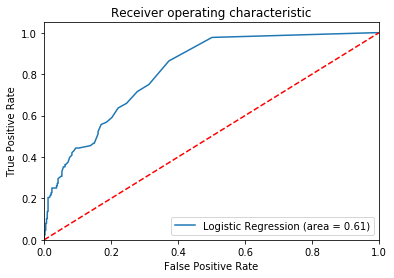

In [78]:
# Print ROC AUC Curve

logit_roc_auc = roc_auc_score(y01_test, bestlogreg.predict(x01_test))
fpr, tpr, thresholds = roc_curve(y01_test, bestlogreg.predict_proba(x01_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Save the model as PMML File

In [79]:
# Save the model as a pmml and use to make predictions in a file 

joblib.dump(bestlogreg, 'LifePropensityModel.pmml') 

['LifePropensityModel.pmml']

### Run the model on entire dataset and save the output in a csv file

In [80]:
# Copy the original data set
df_test = df_orig.copy()

In [81]:
# Separate features into categorical and numerical category
cat_vars = ['FEMALE','MALE','GENDER_UNKNOWN','MARRIED','DIVORCED',
            'SINGLE','MARITAL_STATUS_UNKNOWN','PROFESSION','CHILD',
            'YOUTH','ADULT','SENIOR_CITIZEN','NON_SMOKER','SMOKER',
            'UNDER_WEIGHT','NORMAL_WEIGHT','OVER_WEIGHT','OBESE']

num_vars = ['Q1_BUY', 'Q2_BUY', 'Q3_BUY','Q4_BUY', 'NUMBER_OF_CLAIMS']

In [82]:
# Convert to 'category' object type
for var in cat_vars:
    df_test[var] = df_test[var].astype('category')

In [83]:
# Create Dummy Variables for categorical variables
for var in cat_vars:
    cat_list = 'var'+'_'+var
    cat_list = pd.get_dummies(df_test[var], prefix=var)
    dummy_data = df_test.join(cat_list)
    df_test = dummy_data

In [84]:
# Remove original columns for which dummy variables have been created and ones which will not be required for prediction
vars_remove = ['FEMALE','MALE','GENDER_UNKNOWN','MARRIED','DIVORCED','SINGLE','MARITAL_STATUS_UNKNOWN',
               'PROFESSION','CHILD','YOUTH','ADULT','SENIOR_CITIZEN','NON_SMOKER','SMOKER', 
               'UNDER_WEIGHT','NORMAL_WEIGHT','OVER_WEIGHT','OBESE','CLIENT_NUMBER']

for var in vars_remove:
    df_test=df_test.drop(var, axis=1)

In [85]:
# Get top features
top_features = ['Q1_BUY', 'PROFESSION_Analyst', 'FEMALE_1','MALE_0','PROFESSION_Architect','Q4_BUY',
                'PROFESSION_Applications Consultant','PROFESSION_Juvenile Insured',
                'PROFESSION_Actor/Actress', 'PROFESSION_Doctor']

In [86]:
# Retain only top features in the datframe
df_test=df_test[top_features]

In [87]:
# Make predictions
prediction_class = bestlogreg.predict(df_test)
prediction_prob = bestlogreg.predict_proba(df_test)

# Get Individual Probabilities
notbuy, buy = (prediction_prob).T

In [88]:
# Save original dataframe in a separate dataframe
df_results = df_orig.copy()

In [89]:
# Remove target column
df_results=df_results.drop('HAS_BOUGHT_MORE',axis=1)

In [90]:
# Replace target column with predicted value of '0' or '1' along with respective probablities
df_results['notbuy'] = notbuy
df_results['buy'] = buy
df_results['propensity'] = prediction_class

### Though care has been taken in testing the query output, still double check for duplicate rows for a policy in the csv file

In [91]:
df_results.to_csv('EX_SOURCE_CUSTOMER_PROPENSITY_LIFE.csv', index = None, header=True) 